In [ ]:
import numpy as np
import scipy
import scipy.integrate
import scipy.interpolate
import matplotlib.pyplot as plt
import shared_functions_setup as setup
import shared_functions_wlp_wls as ws
import os.path
import pyccl as ccl
#import main.py as main

plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['cmr10']
plt.rcParams['mathtext.fontset'] ='cm'
data_dir = '/home/b7009348/WGL_project/DES-data/'

- Need to fix some errors in main.py (missing certain files it is calling to, such as boosts txt file)

#### Set up cosmology and halo model quantities

In [ ]:
# Cosmology
cosmo = ccl.Cosmology(Omega_c=0.27, Omega_b=0.045, h=0.67, sigma8=0.83, n_s=0.96)

# Wavenumbers and scale factors
k_arr = np.geomspace(1E-4,1E1,256)
a_arr = np.linspace(0.1,1,32)

# We will use a mass definition with Delta = 200 times the matter density
hmd_200m = ccl.halos.MassDef200m()

# The Duffy 2008 concentration-mass relation
cM = ccl.halos.ConcentrationDuffy08(hmd_200m)

# The Tinker 2008 mass function
nM = ccl.halos.MassFuncTinker08(cosmo, mass_def=hmd_200m)

# The Tinker 2010 halo bias
bM = ccl.halos.HaloBiasTinker10(cosmo, mass_def=hmd_200m)

# The NFW profile to characterize the matter density around halos
pM = ccl.halos.profiles.HaloProfileNFW(cM)

#### Create new HOD class using NCen and NSat from Leonard2018 forecasting
- Need to double check with Danielle what is done here is correct!

In [ ]:
class HaloProfileHOD(ccl.halos.HaloProfileNFW):
    def __init__(self, c_M_relation,
                 lMmin=12.02, lMminp=-1.34,
                 lM0=6.6, lM0p=-1.43,
                 lM1=13.27, lM1p=-0.323):
        self.lMmin=lMmin
        self.lMminp=lMminp
        self.lM0=lM0
        self.lM0p=lM0p
        self.lM1=lM1
        self.lM1p=lM1p
        self.a0 = 1./(1+0.65)
        self.sigmaLogM = 0.4
        self.alpha = 1.
        super(HaloProfileHOD, self).__init__(c_M_relation)
        self._fourier = self._fourier_analytic_hod
    
    def _Nc(self, M, a):
        # Number of centrals

        return ws.get_Ncen_More(M, 'LSST_DESI')
    
    def _Ns(self, M, a):
        # Number of satellites

        return ws.get_Nsat_More(M, 'LSST_DESI')

    def _lMmin(self, a):
        return self.lMmin + self.lMminp * (a - self.a0)

    def _lM0(self, a):
        return self.lM0 + self.lM0p * (a - self.a0)

    def _lM1(self, a):
        return self.lM1 + self.lM1p * (a - self.a0)

    def _fourier_analytic_hod(self, cosmo, k, M, a, mass_def):
        M_use = np.atleast_1d(M)
        k_use = np.atleast_1d(k)
        
        Nc = self._Nc(M_use, a)
        Ns = self._Ns(M_use, a)
        
        # NFW profile
        uk = self._fourier_analytic(cosmo, k_use, M_use, a, mass_def) / M_use[:, None]

        prof = Nc[:, None] * (1 + Ns[:, None] * uk)

        if np.ndim(k) == 0:
            prof = np.squeeze(prof, axis=-1)
        if np.ndim(M) == 0:
            prof = np.squeeze(prof, axis=0)
        return prof

    def _fourier_variance(self, cosmo, k, M, a, mass_def):
        # Fourier-space variance of the HOD profile
        M_use = np.atleast_1d(M)
        k_use = np.atleast_1d(k)

        Nc = self._Nc(M_use, a)
        Ns = self._Ns(M_use, a)
        
        # NFW profile
        uk = self._fourier_analytic(cosmo, k_use, M_use, a, mass_def) / M_use[:, None]

        prof = Ns[:, None] * uk
        prof = Nc[:, None] * (2 * prof + prof**2)

        if np.ndim(k) == 0:
            prof = np.squeeze(prof, axis=-1)
        if np.ndim(M) == 0:
            prof = np.squeeze(prof, axis=0)
        return prof

# this is the galaxy power spectrum calculated from the custom HOD????
pg = HaloProfileHOD(cM)

In [ ]:
# Halo model calculator
hmc = ccl.halos.HMCalculator(cosmo, nM, bM, hmd_200m)

### Use new HOD to compute Galaxy-Galaxy power specturm 
- Only 1 term included? Check in meeting

In [ ]:
class Profile2ptHOD(ccl.halos.Profile2pt):
    def fourier_2pt(self, prof, cosmo, k, M, a,
                      prof2=None, mass_def=None):
        return prof._fourier_variance(cosmo, k, M ,a, mass_def)
HOD2pt = Profile2ptHOD()

# I think this includes 1 and 2 halo terms?    
pk_gg = ccl.halos.halomod_power_spectrum(cosmo, hmc, k_arr, 1.,
                                         pg, prof_2pt=HOD2pt,
                                         normprof1=True)

In [ ]:
plt.figure(figsize=([8,5]))
plt.plot(k_arr, pk_gg, label='$P_{gg}(k)$')
plt.xscale('log')
plt.yscale('log')
plt.legend(fontsize=16)
plt.ylabel(r'$P(k)\,\,[{\rm Mpc}^3]$', fontsize=15)
plt.xlabel(r'$k\,\,[{\rm Mpc}^{-1}]$', fontsize=15);

### Create theoretical redshift distributions for lenses
- Convolve dn/dz with photo-z requirements from LSST SRD

In [ ]:
import customHOD as HOD

In [ ]:
pk_gg = HOD.get_GG_power()

In [ ]:
# this is a makeshift distribution maker based on the SRD 
# document for testing purposes

def get_LSST_dNdz(mode, year, z_arr):
    if year == 1 and mode == 'lens':
        z_0 = 0.26
        alpha = 0.94
        dNdz = z_arr**2 * np.exp(-(z_arr/z_0)**alpha)
    elif year == 10 and mode == 'lens':
        z_0 = 0.28
        alpha = 0.90
        dNdz = z_arr**2. * np.exp(-(z_arr/z_0)**alpha)
    elif year == 1 and mode == 'source':
        z_0 = 0.13
        alpha = 0.78
        dNdz = z_arr**2. * np.exp(-(z_arr/z_0)**alpha)
    elif year == 10 and mode == 'source':
        z_0 = 0.11
        alpha = 0.68
        dNdz = z_arr**2. * np.exp(-(z_arr/z_0)**alpha)
    else:
        print('Not an LSST release year')
        dNdz = 0.
        
    return dNdz

In [ ]:
lens_z_arr = np.linspace(0.2, 1.2, 256)
source_z_arr = np.linspace(0.2, 3.0, 256)

Y1lens_dNdz = get_LSST_dNdz(mode='lens', year=1, z_arr=lens_z_arr)
Y1source_dNdz = get_LSST_dNdz(mode='source', year=1, z_arr=source_z_arr)

lensTracer = ccl.NumberCountsTracer(cosmo, has_rsd=False, dndz=(z_arr, Y1lens_dNdz), 
                                    bias=(lens_z_arr, np.ones(len(lens_z_arr))))
matterTracer = ccl.WeakLensingTracer(cosmo, (source_z_arr, Y1source_dNdz))

In [ ]:
# create 2D power spectrum objects for galaxy-shear correlation

pk_gMf = ccl.halos.halomod_Pk2D(cosmo, hmc, pg, prof2=pM, 
                                normprof1=True, normprof2=True, 
                                lk_arr=np.log(k_arr), a_arr=a_arr)

In [ ]:
ell = np.arange(2,2000)

y1_aps = ccl.angular_cl(cosmo, lensTracer, matterTracer, ell)

In [ ]:
plt.figure(figsize=[6,5])
plt.plot(ell, y1_aps)
plt.xscale('log')
plt.yscale('log')
plt.ylabel(r'$C_{l}$', fontsize=14)
plt.xlabel(r'$\ell$', fontsize=14);

# Scripting and Streamlining HOD and gammaT calculation

### Explanation of LSST forecast data: https://github.com/CosmoLike/DESC_SRD

In [1]:
import spurious_george
import numpy as np

Initialised with Omega_c=0.27, Omega_b=0.045, h=0.67, sigma8=0.83, n_s=0.96. Modify cosmology? Input y or n. n


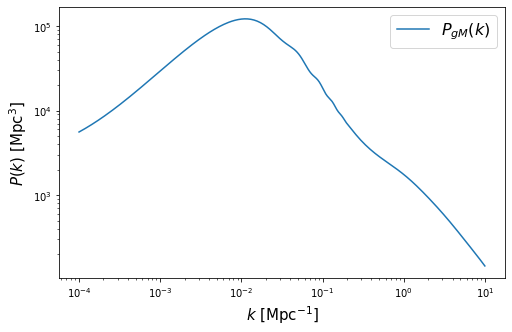

In [2]:
# define wavenumbers
k_arr = np.geomspace(1E-4,1E1,256)

# calculate galaxy-galaxy power spectrum
pk_gM = spurious_george.get_gM_power(k_arr)

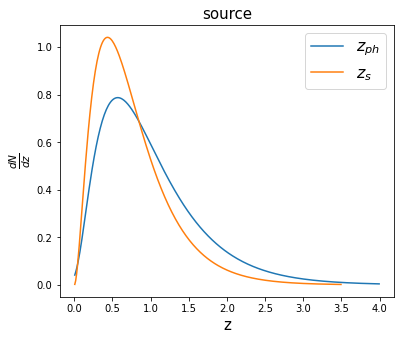

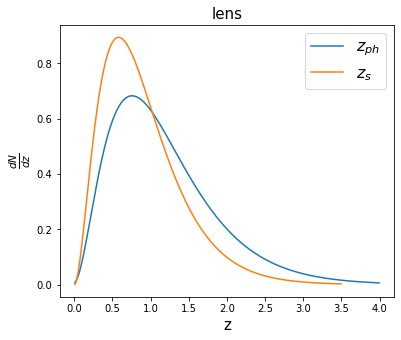

In [3]:
source_dNdz_ph = spurious_george.get_dNdz_phot(gtype='source', year=1, plot_fig='y')

lens_dNdz_ph = spurious_george.get_dNdz_phot(gtype='lens', year=1, plot_fig='y')

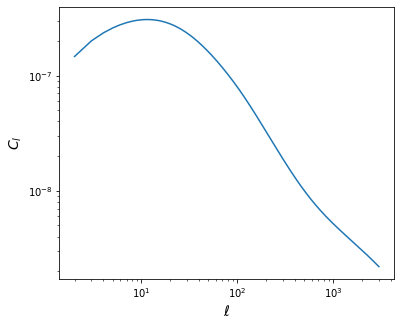

In [4]:
ell = np.arange(2,3000)
a_arr = np.linspace(0.1,1,32)

y1_aps = spurious_george.get_LSST_aps(1, ell, k_arr, a_arr)

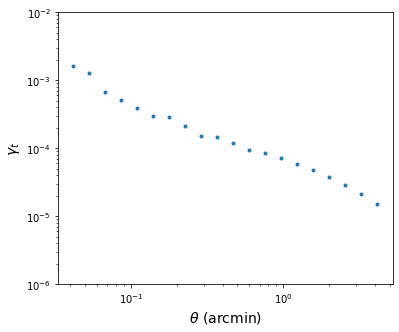

In [5]:
# get gammat

theta_arr = np.logspace(np.log10(2.5), np.log10(250), 20) * 1/60

gammat = spurious_george.get_gammat(y1_aps, theta_arr, ell)

### Estimating F
- Using constant weights for all galaxies, not sure if z_ph dependence is needed
- Value of 0.02238294230501916 seems reasonable (DES Y1 was 0.07)
- Check integration points for num_integrand1 are correct (dz_s between z+ and z-)

In [6]:
import numpy as np
import pyccl as ccl
import scipy.integrate
import astropy.io.fits as fits
cosmo = spurious_george.cosmo

weights = spurious_george.compute_weights()
year = 1

z_s, dNdz_s = spurious_george.get_dNdz_spec(gtype='source', year=year)
z_l, dNdz_l = spurious_george.get_dNdz_spec(gtype='lens', year=year)

# convolve distributions to estimate dNdz_ph, z_ph is
# zs_min <= z_s <= zs_max + 0.5
z_ph, dNdz_ph, p_zs_zph = spurious_george.get_dNdz_phot(gtype='source', year=year)

#convert source and lens spec-z to com-ra-dist
chi_lens = ccl.comoving_radial_distance(cosmo, 1./(1. + z_l))
chi_source = ccl.comoving_radial_distance(cosmo, 1./(1. + z_s))

#find upper and lower IA lims in com-ra-dist
chi_up = chi_lens + 100.
chi_low = chi_lens - 100.

# remove negative distances from result lower lims
chi_low = [0. if x < 0. else x for x in chi_low]
    
#get scale factors for com-ra-dist lims
a_up = ccl.scale_factor_of_chi(cosmo, chi_up)
a_low = ccl.scale_factor_of_chi(cosmo, chi_low)

#convert scale factors to find lims in redshift space
z_up = (1./a_up) - 1.
z_low = (1./a_low) - 1.

# this gets a little confusing... 

# calculate integrand for rightmost numerator integral
integrand1 = dNdz_s * p_zs_zph

# loop over z_+ and z_- for different z_l and integrate between them
num_integral1 = np.zeros(np.shape(p_zs_zph))
for i in range(len(z_up)):
    # sampling points between z_+ and z_-
    z_close = np.linspace(z_low[i], z_up[i], 300)
    # calucalte rightmost integral
    num_integral1[i,:] = scipy.integrate.simps(integrand1, z_close)

# calculate rightmost integral on denominator using same integrand as before
# but over the full z_s range 
denom_integral1 = scipy.integrate.simps(integrand1, z_s)

# multiply solution to first integral by weights and integrate over z_ph
# to find second integral
num_integrand2 = weights * num_integral1
num_integral2 = scipy.integrate.simps(num_integrand2, z_ph)

denom_integrand2 = weights * denom_integral1
denom_integral2 = scipy.integrate.simps(denom_integrand2, z_ph)

# multiply solution to second integral by dNdz_l and integrate over z_l
# to find full numerator and denominator
num_integrand3 = dNdz_l * num_integral2
num_integral3 = scipy.integrate.simps(num_integrand3, z_l)

denom_integrand3 = dNdz_l * denom_integral2
denom_integral3 = scipy.integrate.simps(denom_integrand3, z_l)

# put numerator over denominator to find F
F = num_integral3 / denom_integral3
print(F)

11.899583475460727
0.022382942305019155
